In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Chap 10. 군집분석
## 10.1 유사도 측정
- 연속형 변수
1) 유클리드 거리 $ d_{ij}=\sqrt{\sum^m_{p=1}(x_{ip}-x_{jp})^2}$
    - 재척도화 : 변수들의 영향이 균등하게 되도록 변수의 척도를 재조정
2) 맨해튼 거리 $d_{ij}=\sum^m_{p=1}|x_{ip}-x_{jp}|$
- 범주형 변수 : 더미 변수로 변환 필요
1) 자카드 거리 $ \frac{(1,0) + (0,1)}{(1,1) + (1,0) + (0,1)}$
2) 다이스 거리 $ \frac{(1,0) + (0,1)}{(1,1)\times2 + (1,0) + (0,1)}$
- 연속형, 범주형 변수가 섞일 경우 gower 함수 사용

In [17]:
from scipy.spatial.distance import pdist, squareform

survey = pd.read_csv("../data/kwak/survey.csv").drop('rownames', axis=1)
survey_dummy = pd.get_dummies(survey[['Sex', 'Smoke']], dummy_na=False).T
survey_dist = pd.DataFrame(squareform(pdist(survey_dummy, metric='jaccard')))
survey_dist

,0,1,2,3,4,5
0,0.000000,1.000000,0.959677,0.524038,0.929688,0.961538
1,1.000000,0.000000,0.951220,0.591743,0.921260,0.902439
2,0.959677,0.951220,0.000000,1.000000,1.000000,1.000000
3,0.524038,0.591743,1.000000,0.000000,1.000000,1.000000
4,0.929688,0.921260,1.000000,1.000000,0.000000,1.000000
5,0.961538,0.902439,1.000000,1.000000,1.000000,0.000000


## 10.2 계층적 군집분석
- 모든 케이스가 각자 하나의 군집을 형성하면서 시작하여, 단계별로 유사한 군집끼리 서로 합쳐지며 최종 단계에서는 하나의 군집만 남음
- 각 단계 마다 군집 간 최소거리를 기준으로 개별 케이스들이 기존 군집에 흡수되거나, 결합하는 등 군집 갯수가 줄어듦
- 군집 간 거리 측정
1) 단일연결법 : 모든 케이스 쌍 거리 중 가장 가까운 거리
2) 완전연결법 : 모든 케이스 쌍 거리 중 가장 먼 거리
3) 평균연결법 : 모든 케이스의 평균한 거리
4) 중심연결법 : 중심(centroid)간 거리 사용 (중심은 평균)
5) 최소분산연결법 : 모든 케이스 간의 총 분산거리

- 의미있는 계층적 군집 기대 가능 
- 군집화 알고리즘 상 케이스가 특정 군집에 할당 시 끝날 떄 까지 소속군집이 변하지 않음
- 샘플 수가 늘어나므로 거리를 계산해야해서 느려짐

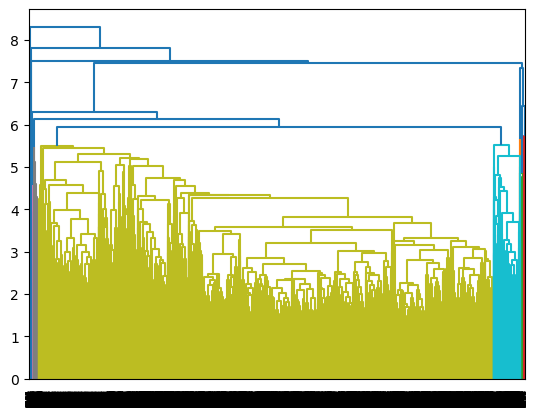

In [7]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

loan = pd.read_csv('../data/kwak/loan_data.csv').drop(['purpose', 'not.fully.paid'], axis=1)

# 이상치 제거
for col in list(loan.columns):
    Q1 = loan[col].quantile(0.05)
    Q3 = loan[col].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    loan = loan.loc[(loan[col] >= lower) & (loan[col] <= upper)]

# rescaling
scaler = StandardScaler()
loan_scaled = scaler.fit_transform(loan)

# dendrogram y축이 샘플간 거리 : 가장 높은 수직 선에 수평선을 긋고, 교차점이 적절 군집 갯수
average_cluster = linkage(loan_scaled, method='average', metric='euclidean')
R = dendrogram(average_cluster);
plt.show()

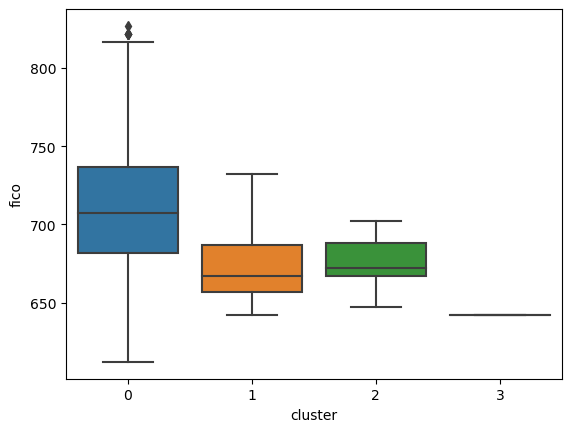

In [21]:
# 군집 도출
from scipy.cluster.hierarchy import cut_tree

loan['cluster'] =  cut_tree(average_cluster, n_clusters=4).reshape(-1,)
sns.boxplot(x='cluster', y='fico', data=loan);

In [29]:
temp = loan.groupby('cluster', as_index=False).mean()
pd.DataFrame(scaler.fit_transform(temp.iloc[:, 1:]), columns=temp.iloc[:, 1:].columns)

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
0,0.969552,-1.557650,-0.078046,0.487719,0.103177,1.475568,-0.145697,1.279435,-0.476301,-0.110313,-0.706988,-0.609494
1,-0.726231,-0.149346,0.068981,0.553606,0.190929,-0.140397,0.266557,0.576871,-0.146748,1.659008,-0.086190,1.722668
2,0.997034,0.636123,1.416820,0.686291,-1.545204,0.007561,1.336068,-0.536149,-1.022174,-0.639639,1.657179,-0.412795
3,-1.240355,1.070873,-1.407754,-1.727616,1.251098,-1.342732,-1.456929,-1.320156,1.645224,-0.909057,-0.864001,-0.700379


## 10.3 비계층적 군집분석

### K-mean clustering
- 개별 케이스와 k개 중심점과의 거리를 측정하여 가장 가까운 거리를 갖는 군집에 개별 케이스 할당
- 수행 절차
    1) 최초 k개 중심점 선택
    2) 중심점과 개별 케이스 간 거리 바탕으로 케이스 분류
    3) 각 군집에 할당된 케이스들을 이용하여 새로운 군집평균 계산하고 다시 분류
    4) 군집 평균에 더 이상 큰 변화가 없을 때 까지 반복
- 큰 규모 데이터셋 가능
- 케이스는 매 단계 마다 소속 군집 변경 가능
- 평균을 사용하므로 모든 변수가 연속형이어야하며, 분석결과가 이상점에 의해 영향 받을 수 있음
- scoring
    - wcss : within clusters sum of squares
    - silhouette : 다른 클러스터(seperation)에 비해 자신의 클러스터(cohesion)와 얼마나 유사한지

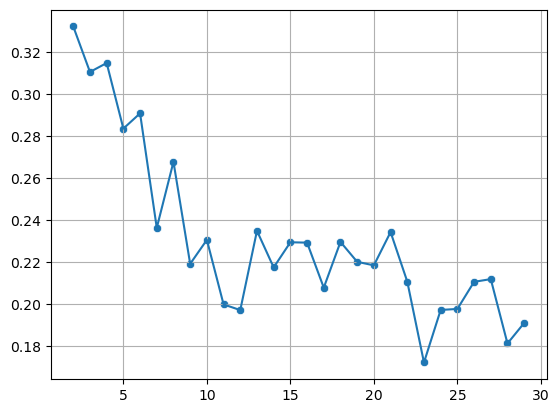

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

state = pd.read_csv("../data/kwak/state.x77.csv", index_col=0)

scaler = StandardScaler()
state_scaled = pd.DataFrame(scaler.fit_transform(state), columns=state.columns, index=state.index)

wcss_scores = {}
silhouette_scores = {}
for i in range(2,30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=1).fit(state_scaled)
    wcss_scores[i] = kmeans.inertia_
    silhouette_scores[i] = silhouette_score(state_scaled, kmeans.labels_)

# silhouette
sns.lineplot(x=silhouette_scores.keys(), y=silhouette_scores.values());
sns.scatterplot(x=silhouette_scores.keys(), y=silhouette_scores.values());
plt.grid()
plt.show()

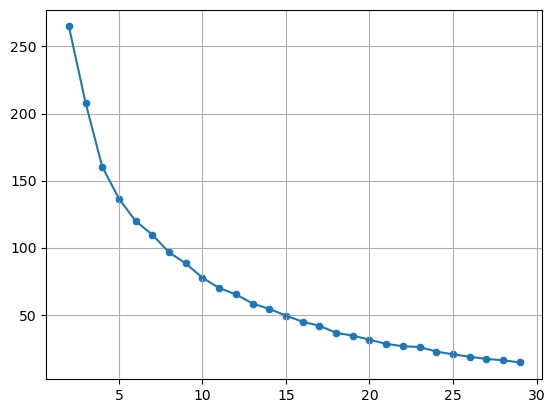

In [54]:
# elbow method
sns.lineplot(x=wcss_scores.keys(), y=wcss_scores.values());
sns.scatterplot(x=wcss_scores.keys(), y=wcss_scores.values());
plt.grid()
plt.show()

In [67]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=500, random_state=1).fit(state_scaled)
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=state_scaled.columns)

,Population,Income,Illiteracy,Life Exp,Murder,HS Grad,Frost,Area
0,8201.714286,4941.785714,1.100000,70.410714,9.278571,54.864286,98.500000,98050.928571
1,3983.333333,3682.083333,2.033333,69.431667,11.475000,42.150000,64.333333,68380.750000
2,2070.708333,4517.500000,0.779167,71.875000,4.220833,57.562500,128.000000,55979.666667


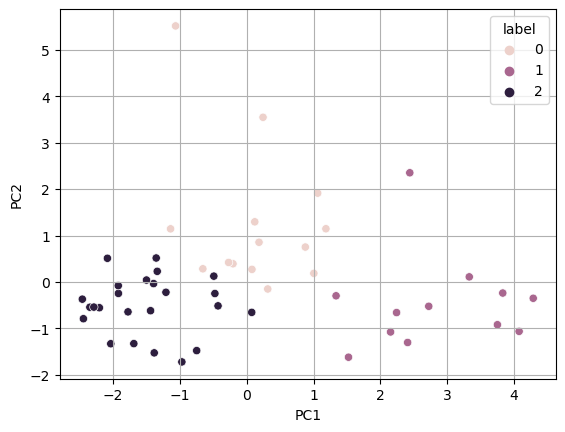

In [68]:
# plotting with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=1).fit(state_scaled)
state_pca = pd.DataFrame(pca.transform(state_scaled), columns=map(lambda x: 'PC'+str(x), range(1,3)))
state_pca['label'] = kmeans.labels_

sns.scatterplot(x=state_pca['PC1'], y=state_pca['PC2'], hue=state_pca['label']);
plt.grid();

## 10.3 PAM 군집분석
- partitioning around medoids cluster analysis
- 이상점에 취약한 평균 대신 실제 관측값 중 하나를 군집으로 대표하는 중심점(medoid)로 사용
- 여러 유형이 혼재된 변수 유형에 대해서 분석 수행
- 수행절차
1) 최초 메도이드인 k개 케이스 무작위 선택
2) 모든 케이스와 각 메도이드 간의 거리를 계산하여 케이스들ㅇ르 가장 가까운 메도이드 군집에 할당
    - 메도이드와 각 케이스 간의 거리 합을 군집의 총 비용이라고 함
3) 현재 메도이드가 아닌 케이스 중에서 새로운 메도이드 후보 선택 후 군집할당과 총 비용 계산 작업 수행
4) 총 비용이 더 이상 개선되지 않을 때까지 반복 수행


In [109]:
from sklearn.preprocessing import StandardScaler

wine = pd.read_csv("../data/kwak/wine.csv")
wine_data = wine.iloc[:,1:]
wine_type = wine['Type']

scaler = StandardScaler()
wine_scaled = pd.DataFrame(scaler.fit_transform(wine_data), columns=wine_data.columns)
wine_scaled.head()

,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [110]:
from sklearn_extra.cluster import KMedoids
pam = KMedoids(n_clusters=3, metric='euclidean', method='pam', random_state=1).fit(wine_scaled)

pd.DataFrame(pam.labels_).value_counts()

2    74
1    55
0    49
dtype: int64

In [112]:
pd.DataFrame(scaler.inverse_transform(pam.cluster_centers_), columns=wine_scaled.columns)

,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,13.32,3.24,2.38,21.5,92.0,1.93,0.76,0.45,1.25,8.42,0.55,1.62,650.0
1,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0
2,13.48,1.81,2.41,20.5,100.0,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920.0


In [93]:
# sum of distances of samples to their closest cluster center
pam.inertia_

16375.8891494725

In [92]:
pam.medoid_indices_

array([ 50,  72, 135])

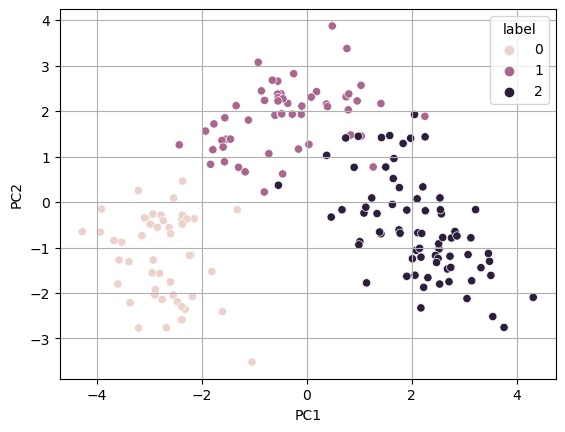

In [113]:
# plotting with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=1).fit(wine_scaled)
wine_pca = pd.DataFrame(pca.transform(wine_scaled), columns=map(lambda x: 'PC'+str(x), range(1,3)))
wine_pca['label'] = pam.labels_

sns.scatterplot(x=wine_pca['PC1'], y=wine_pca['PC2'], hue=wine_pca['label']);
plt.grid();

In [127]:
# 군집분석 정확도 확인
from sklearn.metrics import confusion_matrix, accuracy_score

wine_type = list(map(lambda x : 1 if x==1 else (2 if x==2 else 0), wine_type))
print(confusion_matrix(pam.labels_, wine_type))
print("\n", accuracy_score(pam.labels_, wine_type))

[[48  1  0]
 [ 0 55  0]
 [ 0 15 59]]

 0.9101123595505618
